In [70]:
import hashlib

from math import radians, cos, sin, asin, sqrt
from scipy.stats import randint, uniform

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta

from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold

from sklego.preprocessing import TypeSelector

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier


from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold

from sklego.meta import Thresholder
from sklearn.metrics import classification_report, average_precision_score
from xgboost import XGBClassifier
import joblib

## Data Dictionary

- trans_date_trans_time: The timestamp indicating when the transaction occurred.
- cc_num: Credit card number used for the transaction.
- merchant: The name or identifier of the merchant where the transaction took place.
- category: The category of the transaction (e.g., groceries, electronics, etc.).
- amt: The amount of money involved in the transaction.
- first: The first name of the cardholder.
- last: The last name of the cardholder.
- gender: Gender of the cardholder.
- street: The street address of the cardholder.
- city: The city where the cardholder resides.
- state: The state where the cardholder resides.
- zip: The ZIP code of the cardholder's location.
- lat: Latitude coordinate of the cardholder's location.
- long: Longitude coordinate of the cardholder's location.
- city_pop: The population of the city where the cardholder resides.
- job: The occupation or job title of the cardholder.
- dob: Date of birth of the cardholder.
- trans_num: Transaction number or identifier.
- unix_time: The transaction timestamp in UNIX time format.
- merch_lat: Latitude coordinate of the merchant's location.
- merch_long: Longitude coordinate of the merchant's location.
- is_fraud: Binary indicator (0 or 1) denoting whether the transaction is fraudulent (1) or not (0).

In [2]:
data_train = pd.read_csv(r"datasets/fraudTrain.csv")
data_test = pd.read_csv(r"datasets/fraudTest.csv")

df = pd.concat([data_train, data_test])

df.head().T

# CREATE unique identifying columns for customers and Merchants
df['customer_id'] = df.apply(lambda x: hashlib.md5(
    f"{x['first']}_{x['last']}_{x['dob']}".encode()
).hexdigest()[:10],axis= 1)

df["merchant_id"] = df['merchant'].apply(
    lambda x: hashlib.md5(x.encode()).hexdigest()[:8]
)

# rename trans_num to transaction ID
df.rename(columns={'trans_num': "trans_id"}, inplace= True)

df.to_csv("fraud_data.csv", index= False)

In [3]:
df.shape

(1852394, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 25 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_id               object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud               i

In [5]:
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [6]:
df['unix_time']

0         1325376018
1         1325376044
2         1325376051
3         1325376076
4         1325376186
             ...    
555714    1388534347
555715    1388534349
555716    1388534355
555717    1388534364
555718    1388534374
Name: unix_time, Length: 1852394, dtype: int64

In [7]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_id', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'customer_id', 'merchant_id'],
      dtype='object')

In [8]:
# convert the trans date trans time column to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df = df.sort_values(by= 'trans_date_trans_time')
df = df.drop(columns = 'Unnamed: 0')
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_id,unix_time,merch_lat,merch_long,is_fraud,customer_id,merchant_id
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0a4982e1af,5f793646
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,9296fc5d43,7ec9d250
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,b21888763d,87c178a8
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,7314d1a617,17ebab46
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,a549abd8ab,c4ab78c9


In [9]:
df.tail()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_id,unix_time,merch_lat,merch_long,is_fraud,customer_id,merchant_id
555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,f31b65ada5,26fcafbf
555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,55c738a993,63ff1181
555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,b0a36e60bf,541b862f
555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,43cc9dd7ee,8698b75f
555718,2020-12-31 23:59:34,4170689372027579,fraud_Dare-Marvin,entertainment,38.13,Samuel,Frey,M,830 Myers Plaza Apt. 384,Edmond,...,116001,Media buyer,1993-05-10,1765bb45b3aa3224b4cdcb6e7a96cee3,1388534374,36.210097,-97.036372,0,2159c5d4bf,4ae77838


In [10]:
# Unique values in the target variable
print(df["is_fraud"].value_counts(normalize= True) * 100)
print(df["is_fraud"].value_counts())

is_fraud
0    99.478999
1     0.521001
Name: proportion, dtype: float64
is_fraud
0    1842743
1       9651
Name: count, dtype: int64


## Note

The dataset is hugely imbalanced, with less than 8k rows of data actually fraudulent transactions

## EDA

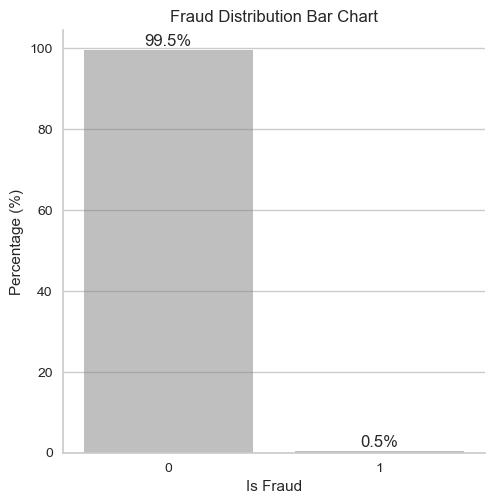

In [11]:
# visualize the distribution of the target variable
# Compute percentages
fraud_dist = df["is_fraud"].value_counts(normalize=True) * 100
fraud_df = fraud_dist.reset_index()
fraud_df.columns = ["is_fraud", "percentage"]

# Plot
sns.catplot(
    data=fraud_df,
    x="is_fraud",
    y="percentage",
    kind="bar",
    color="grey",
    alpha=0.5
)

plt.title("Fraud Distribution Bar Chart")
plt.xlabel("Is Fraud")
plt.ylabel("Percentage (%)")

# Annotate each bar
for i, row in fraud_df.iterrows():
    plt.text(i, row["percentage"] + 1, f"{row['percentage']:.1f}%", ha="center")

plt.show()


In [12]:
df['state'].unique()

array(['NC', 'WA', 'ID', 'MT', 'VA', 'PA', 'KS', 'TN', 'IA', 'WV', 'FL',
       'CA', 'NM', 'NJ', 'OK', 'IN', 'MA', 'TX', 'WI', 'MI', 'WY', 'HI',
       'NE', 'OR', 'LA', 'DC', 'KY', 'NY', 'MS', 'UT', 'AL', 'AR', 'MD',
       'GA', 'ME', 'AZ', 'MN', 'OH', 'CO', 'VT', 'MO', 'SC', 'NV', 'IL',
       'NH', 'SD', 'AK', 'ND', 'CT', 'RI', 'DE'], dtype=object)

In [13]:
print(df[['lat', 'long']].head(10))

       lat      long
0  36.0788  -81.1781
1  48.8878 -118.2105
2  42.1808 -112.2620
3  46.2306 -112.1138
4  38.4207  -79.4629
5  40.3750  -75.2045
6  37.9931 -100.9893
7  38.8432  -78.6003
8  40.3359  -79.6607
9  36.5220  -87.3490


In [14]:
df[["lat", "long"]].describe()

,lat,long
count,1.852394e+06,1.852394e+06
mean,3.853931e+01,-9.022783e+01
std,5.071470e+00,1.374789e+01
min,2.002710e+01,-1.656723e+02
25%,3.466890e+01,-9.679800e+01
50%,3.935430e+01,-8.747690e+01
75%,4.194040e+01,-8.015800e+01
max,6.669330e+01,-6.795030e+01


In [15]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_id', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'customer_id', 'merchant_id'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 24 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    object        
 17  trans_id               object        
 18  unix_time              int64

In [17]:
df['city'].nunique()

906

In [18]:
df['state'].nunique()

51

In [19]:
df['merchant'].nunique()

693

In [20]:
df['job'].nunique()

497

In [21]:
df['category'].nunique()
print(df['category'].unique())

['misc_net' 'grocery_pos' 'entertainment' 'gas_transport' 'misc_pos'
 'grocery_net' 'shopping_net' 'shopping_pos' 'food_dining' 'personal_care'
 'health_fitness' 'travel' 'kids_pets' 'home']


In [22]:
pd.to_datetime(df['dob'])

0        1988-03-09
1        1978-06-21
2        1962-01-19
3        1967-01-12
4        1986-03-28
            ...    
555714   1966-02-13
555715   1999-12-27
555716   1981-11-29
555717   1965-12-15
555718   1993-05-10
Name: dob, Length: 1852394, dtype: datetime64[ns]

## Feature Engineering


In [23]:
df['day_of_week']= df['trans_date_trans_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour
df["is_night"] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] < 6)).astype(int)
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (datetime.today().year - df['dob'].dt.year)
df['day_of_week'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int32)

In [24]:
df['cc_num'].nunique()

999

In [25]:
df[['first', 'last', 'cc_num']].duplicated().sum()

np.int64(1851395)

In [26]:
df[['first', 'last']].duplicated().sum()

np.int64(1851405)

In [27]:
df.shape

(1852394, 29)

In [28]:
pd.set_option('display.max_columns', 30)
df.sample(20)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_id,unix_time,merch_lat,merch_long,is_fraud,customer_id,merchant_id,day_of_week,is_weekend,hour_of_day,is_night,age
873354,2019-12-21 02:29:47,373905417449658,fraud_Bednar Group,misc_net,17.11,Sarah,Bishop,F,554 Mcdonald Valley Apt. 539,Meridian,TX,76665,31.9290,-97.6443,2526,Phytotherapist,1970-11-12,cb43a187b8c803634d0d55540401d0fc,1356056987,31.169742,-97.388334,0,57f71a56ad,86e6f879,5,1,2,1,55
733648,2019-11-09 22:22:18,375974680629816,"fraud_Wuckert, Wintheiser and Friesen",home,80.14,Roberta,Mccarthy,F,94431 Matthew Mall Suite 296,Plymouth,CT,6782,41.6611,-73.0449,2376,Herpetologist,1973-04-06,6ce1acf99c785c785afc19193bdb3648,1352499738,41.803182,-73.006407,0,899c9ef584,7be3de1c,5,1,22,1,52
412931,2020-11-30 14:21:26,2286236465059468,fraud_Labadie LLC,personal_care,31.98,Morgan,Murray,F,2788 Brittney Island,Blairstown,MO,64726,38.5319,-93.9221,467,Agricultural consultant,1950-05-27,07fc008e2aee3d0c6a2fd8a002614791,1385821286,37.921946,-93.176330,0,6e2218477f,238833fa,0,0,14,0,75
261289,2019-05-10 11:14:26,180011453250192,fraud_Pacocha-O'Reilly,grocery_pos,97.80,Craig,Dunn,M,721 Jacqueline Brooks,New Boston,IL,61272,41.2153,-90.9879,1504,Manufacturing engineer,1993-10-05,3e852bb7f82d10817d23980f31dd490c,1336648466,41.490360,-91.716997,0,cfed99d2dd,4e4e8c1d,4,0,11,0,32
88391,2019-02-21 21:02:33,2712209726293386,fraud_Romaguera Ltd,health_fitness,15.29,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,LA,70808,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,82a85bccd6564a72da1ac13d37b981f8,1329858153,30.953353,-91.484690,0,fea20e49ef,5bae4602,3,0,21,0,48
426233,2019-07-10 11:10:58,4979422371139333,fraud_Sporer Inc,gas_transport,59.24,Kelly,Zimmerman,F,1893 Katie Tunnel,Westerville,NE,68881,41.4193,-99.3844,73,Product designer,1935-02-10,bbacc94c7321ae37dd31e98939146d6a,1341918658,41.885663,-99.896808,0,9f70b92f0c,b593dd26,2,0,11,0,90
1274182,2020-06-13 13:50:33,4474324669797121,fraud_Schoen-Quigley,kids_pets,129.78,Matthew,Russell,M,168 Michael Coves Suite 343,June Lake,CA,93529,37.7773,-119.0825,633,Health service manager,1927-09-09,2f91e76c0db3d8ef334c22bc7ad7dd25,1371131433,37.238207,-118.520454,0,5d079b6213,29913a73,5,1,13,0,98
239462,2019-04-29 21:22:47,4092452671396169678,fraud_Graham and Sons,health_fitness,70.00,Jeffrey,Vargas,M,478 Alexandria Mount,Bolton,NC,28423,34.3091,-78.3372,2290,"Engineer, biomedical",1945-12-07,6b1cc372cc3c52ccc64b0de4f06e3290,1335734567,34.848635,-78.727534,0,82374638c9,c2eec2fb,0,0,21,0,80
499814,2020-12-19 23:43:34,6011679934075347,"fraud_Goyette, Howell and Collier",shopping_pos,1.05,Jennifer,Gonzalez,F,5517 Stacy Land,Jelm,WY,82063,41.0539,-106.0763,100,Public librarian,1974-04-16,1624e3a06a6aca9f9c61ecd447b37297,1387496614,40.124476,-106.277000,0,a9c25f2153,f0de9c63,5,1,23,1,51
313977,2020-10-18 21:10:38,581293083266,fraud_Daugherty LLC,kids_pets,59.10,William,Thomas,M,39227 Mcpherson Shoals,Lahoma,OK,73754,36.3850,-98.0727,1078,Podiatrist,1989-10-06,32c22333b36b4905ba649dfe15e5c6d3,1382130638,36.102781,-98.063736,0,ec940e1dac,bea2b684,6,1,21,0,36


In [29]:
# check the columns in the datases
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_id', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'customer_id', 'merchant_id', 'day_of_week',
       'is_weekend', 'hour_of_day', 'is_night', 'age'],
      dtype='object')

In [30]:
print(sorted(df['age'].unique()))

[np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31), np.int32(32), np.int32(33), np.int32(34), np.int32(35), np.int32(36), np.int32(37), np.int32(38), np.int32(39), np.int32(40), np.int32(41), np.int32(42), np.int32(43), np.int32(44), np.int32(45), np.int32(46), np.int32(47), np.int32(48), np.int32(49), np.int32(50), np.int32(51), np.int32(52), np.int32(53), np.int32(54), np.int32(55), np.int32(56), np.int32(57), np.int32(58), np.int32(59), np.int32(60), np.int32(61), np.int32(62), np.int32(63), np.int32(64), np.int32(65), np.int32(66), np.int32(67), np.int32(68), np.int32(69), np.int32(70), np.int32(71), np.int32(72), np.int32(73), np.int32(74), np.int32(75), np.int32(76), np.int32(77), np.int32(78), np.int32(79), np.int32(80), np.int32(81), np.int32(82), np.int32(83), np.int32(84), np.int32(85), np.int32(86), np.int32(87), np.int32(88), np.int32(89), np.int32(90), np.in

<Axes: xlabel='age', ylabel='Count'>

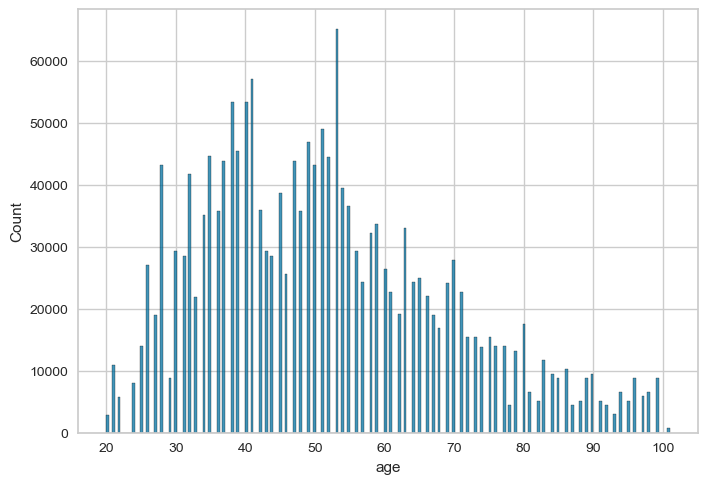

In [31]:
sns.histplot(
    data= df,
    x = "age"
)

In [32]:
df.dtypes

trans_date_trans_time    datetime64[ns]
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_id                         object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
customer_id                      object
merchant_id                      object
day_of_week                       int32


In [33]:
# create age group to confirm if customer age affects if they are prone to fraud
age_bins = [0, 29, 45, 60, 200]
age_labels = ["18-28", "29-44", "45-60", "60+"]
df['age_groups'] = pd.cut(df['age'], bins= age_bins, labels= age_labels, right= False)

In [34]:
drop_cols = ["cc_num", "first", "last", "street", "city", "merchant", "job", "zip", "dob", "unix_time", "age", "state"]
df = df.drop(columns= drop_cols)

In [35]:
# Sort the dataframe for better indexing
df = df.sort_values(['customer_id', 'trans_date_trans_time'])

### Transaction History of Customers

In [36]:
def rolling_transactions(group, duration:str):
    # Set datetime index and calculate rolling count
    temp = group.set_index('trans_date_trans_time')
    rolling_count = temp.rolling(duration)['amt'].count()
    # Reset index to match original group structure
    rolling_count.index = group.index
    return rolling_count

df['customer_num_transactions_1_day'] = (
    df.groupby("customer_id", group_keys=False)
    .apply(lambda x: rolling_transactions(x, '1D'))
)

C:\Users\HP\AppData\Local\Temp\ipykernel_39624\1243360270.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: rolling_transactions(x, '1D'))


In [37]:
df['customer_num_transactions_7_day'] = (
    df.groupby("customer_id", group_keys=False)
    .apply(lambda x: rolling_transactions(x, '7D'))
)


df['customer_num_transactions_30_day'] = (
    df.groupby("customer_id", group_keys=False)
    .apply(lambda x: rolling_transactions(x, '30D'))
)

C:\Users\HP\AppData\Local\Temp\ipykernel_39624\179459044.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: rolling_transactions(x, '7D'))
C:\Users\HP\AppData\Local\Temp\ipykernel_39624\179459044.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: rolling_transactions(x, '30D'))


In [38]:
# Customer average transaction amount across day ranges 1 day, 7 days, 30 days
def rolling_avg_amt(group, duration:str):
    # Set datetime index and calculate rolling count
    temp = group.set_index('trans_date_trans_time')
    rolling_mean = temp.rolling(duration)['amt'].mean()
    # Reset index to match original group structure
    rolling_mean.index = group.index
    return rolling_mean


In [39]:
df['customer_avg_amt_1_day'] = (
    df.groupby("customer_id", group_keys=False)
    .apply(lambda x: rolling_avg_amt(x, '1D'))
)


df['customer_avg_amt_7_day'] = (
    df.groupby("customer_id", group_keys=False)
    .apply(lambda x: rolling_avg_amt(x, '7D'))
)


df['customer_avg_amt_30_day'] = (
    df.groupby("customer_id", group_keys=False)
    .apply(lambda x: rolling_avg_amt(x, '30D'))
)

C:\Users\HP\AppData\Local\Temp\ipykernel_39624\1267076806.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: rolling_avg_amt(x, '1D'))
C:\Users\HP\AppData\Local\Temp\ipykernel_39624\1267076806.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: rolling_avg_amt(x, '7D'))
C:\Users\HP\AppData\Local\Temp\ipykernel_39624\1267076806.py:15: FutureWarning: DataFrameGroupBy.apply operated on

### Transaction History of Merchants

Atleast a 7-day delay is a crucial concept in fraud detection that prevents data leakage and makes the model more realistic for real-world deployment.
Why the delay exists:

- Fraud Discovery Lag: In reality, fraud isn't detected immediately when it occurs. It often takes days or weeks to discover:

Customer notices unauthorized charges on their statement
Bank's fraud detection systems flag suspicious patterns
Merchant reports chargebacks


- Prevents Data Leakage: Without the delay, your model would use "future information" that wouldn't be available at prediction time:

If you're predicting fraud for a transaction on Day 10
Without delay: You'd use fraud rates including Days 10-17 (using future fraud labels)
With 7-day delay: You only use fraud rates from Days 1-10 (realistic historical data)


- Real-World Deployment: When deploying the model in production:

You can only use historical fraud data that's already been confirmed
Recent transactions (last 7 days) haven't been fully investigated yet

In [40]:
DAY_DELAY = 7

def get_count_risk_rolling_window(
    terminal_transactions, window_size, delay_period=DAY_DELAY
):
    frauds_in_delay = terminal_transactions.rolling(
        str(delay_period) + "d", on="trans_date_trans_time"
    )["is_fraud"].sum()
    transactions_in_delay = terminal_transactions.rolling(
        str(delay_period) + "d", on="trans_date_trans_time"
    )['is_fraud'].count()

    frauds_until_window = terminal_transactions.rolling(
        str(delay_period + window_size) + "d", on="trans_date_trans_time"
    )['is_fraud'].sum()

    transactions_until_window = terminal_transactions.rolling(
        str(delay_period + window_size) + "d", on="trans_date_trans_time"
    )['is_fraud'].count()

    frauds_in_window = frauds_until_window - frauds_in_delay
    transactions_in_window = transactions_until_window - transactions_in_delay

    terminal_transactions['fraud_risk'] = (
        frauds_in_window /transactions_in_window
    ).fillna(0)

    return terminal_transactions


In [41]:
df = df.sort_values(['merchant_id', 'trans_date_trans_time'])

In [42]:
df['merchant_num_transactions_1_day'] = (
    df.groupby("merchant_id", group_keys=False)
    .apply(lambda x: rolling_transactions(x, '1D'))
)


df['merchant_num_transactions_7_day'] = (
    df.groupby("merchant_id", group_keys=False)
    .apply(lambda x: rolling_transactions(x, '7D'))
)


df['merchant_num_transactions_30_day'] = (
    df.groupby("merchant_id", group_keys=False)
    .apply(lambda x: rolling_transactions(x, '30D'))
)

C:\Users\HP\AppData\Local\Temp\ipykernel_39624\2213273339.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: rolling_transactions(x, '1D'))
C:\Users\HP\AppData\Local\Temp\ipykernel_39624\2213273339.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: rolling_transactions(x, '7D'))
C:\Users\HP\AppData\Local\Temp\ipykernel_39624\2213273339.py:15: FutureWarning: DataFrameGroupBy.apply o

In [43]:
df['merchant_fraud_risk_1_day'] = df.groupby(
    "merchant_id", group_keys= False
).apply(
    lambda x: get_count_risk_rolling_window(x, 1, 7)
)['fraud_risk']


df['merchant_fraud_risk_7_day'] = df.groupby(
    "merchant_id", group_keys= False
).apply(
    lambda x: get_count_risk_rolling_window(x, 7, 7)
)['fraud_risk']

df['merchant_fraud_risk_30_day'] = df.groupby(
    "merchant_id", group_keys= False
).apply(
    lambda x: get_count_risk_rolling_window(x, 30, 7)
)['fraud_risk']

C:\Users\HP\AppData\Local\Temp\ipykernel_39624\1246369651.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(
C:\Users\HP\AppData\Local\Temp\ipykernel_39624\1246369651.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(
C:\Users\HP\AppData\Local\Temp\ipykernel_39624\1246369651.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future

In [44]:
df.head()

,trans_date_trans_time,category,amt,gender,lat,long,city_pop,trans_id,merch_lat,merch_long,is_fraud,customer_id,merchant_id,day_of_week,is_weekend,hour_of_day,is_night,age_groups,customer_num_transactions_1_day,customer_num_transactions_7_day,customer_num_transactions_30_day,customer_avg_amt_1_day,customer_avg_amt_7_day,customer_avg_amt_30_day,merchant_num_transactions_1_day,merchant_num_transactions_7_day,merchant_num_transactions_30_day,merchant_fraud_risk_1_day,merchant_fraud_risk_7_day,merchant_fraud_risk_30_day
1196,2019-01-01 14:15:19,entertainment,67.86,M,40.9661,-76.8575,645,a851947895d831bab0e608b4f3f6dec3,40.949038,-76.169227,0,ffd007a516,00664b3e,1,0,14,0,45-60,2.0,2.0,2.0,55.925000,55.925000,55.925000,1.0,1.0,1.0,0.0,0.0,0.0
1990,2019-01-01 20:31:41,entertainment,36.91,F,29.7972,-95.3288,2906700,1e34533bd8b26a579902f1189c8ad74f,28.924370,-94.826336,0,1f6d76a0ac,00664b3e,1,0,20,0,29-44,2.0,2.0,2.0,44.285000,44.285000,44.285000,2.0,2.0,2.0,0.0,0.0,0.0
3484,2019-01-02 23:17:25,entertainment,159.94,F,39.8936,-79.7856,328,ddc609252e7b3f2eb9db3ed58258826a,40.086256,-79.464567,0,ecc8c2b330,00664b3e,2,0,23,1,29-44,3.0,8.0,8.0,73.396667,61.718750,61.718750,1.0,3.0,3.0,0.0,0.0,0.0
4076,2019-01-03 13:12:33,entertainment,91.98,F,31.6489,-82.1982,1324,da681605428e538e5c9c7325b2fc9095,31.022453,-81.872300,0,ae1f688c53,00664b3e,3,0,13,0,60+,2.0,9.0,9.0,47.735000,234.691111,234.691111,2.0,4.0,4.0,0.0,0.0,0.0
5564,2019-01-04 15:12:01,entertainment,70.36,M,38.5234,-120.6763,832,9f00699d6bdcac8d2fae9d4c40f3e28a,38.224537,-120.641298,0,4ac4fcda94,00664b3e,4,0,15,0,29-44,7.0,15.0,15.0,81.244286,74.123333,74.123333,1.0,5.0,5.0,0.0,0.0,0.0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 1196 to 555295
Data columns (total 30 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   trans_date_trans_time             datetime64[ns]
 1   category                          object        
 2   amt                               float64       
 3   gender                            object        
 4   lat                               float64       
 5   long                              float64       
 6   city_pop                          int64         
 7   trans_id                          object        
 8   merch_lat                         float64       
 9   merch_long                        float64       
 10  is_fraud                          int64         
 11  customer_id                       object        
 12  merchant_id                       object        
 13  day_of_week                       int32         
 14  is_weekend           

## Split data into Train, Test, Validation datasets

In [46]:
def split_datasets(df,  start_date_training, delta_train = 21, delta_delay = 1, delta_test = 7, delta_val = 7):
    # Training set
    train_end = start_date_training + timedelta(days= delta_train)
    train_df = df[
        (df["trans_date_trans_time"] >= start_date_training) &
        (df['trans_date_trans_time'] < train_end)
    ]

    known_defrauded_customers = set(train_df[train_df['is_fraud'] == 1]["customer_id"])

    # Test set with delay
    test_start = train_end + timedelta(days = delta_delay)
    test_end = test_start + timedelta(days = delta_test)
    test_df = df[
        (df['trans_date_trans_time'] >= test_start) &
        (df['trans_date_trans_time'] < test_end) &
        ~df['customer_id'].isin(known_defrauded_customers)
    ]

    # Validation set
    val_start = test_end
    val_end = val_start + timedelta(days = delta_val)
    val_df = df[
        (df['trans_date_trans_time'] >= val_start) &
        (df['trans_date_trans_time'] < val_end)
    ]

    return train_df, test_df, val_df

In [47]:
# Define different values of Day_DELAY for different datasets
day_delay_values = [1, 7]

# Create datasets with different DAY_DELAY values
datasets = []

for day_delay in day_delay_values:
    train_df, test_df, val_df = split_datasets(df, datetime(2019, 1, 1), delta_train= 21, delta_delay= day_delay, delta_val= 14)

    datasets.append({
        "train_df": train_df,
        "test_df": test_df,
        "val_df": val_df,
        "day_delay": day_delay
    })

for dataset in datasets:
    print(f"DAY_DELAY: {dataset['day_delay']}")
    print("Number of samples in training:", len(dataset['train_df']))
    print("Number of samples in test set:", len(dataset['test_df']))
    print("Number of samples in validation set:", len(dataset['val_df']))
    print()

DAY_DELAY: 1
Number of samples in training: 36037
Number of samples in test set: 11375
Number of samples in validation set: 24106

DAY_DELAY: 7
Number of samples in training: 36037
Number of samples in test set: 11547
Number of samples in validation set: 24007



In [48]:
train_df.columns

Index(['trans_date_trans_time', 'category', 'amt', 'gender', 'lat', 'long',
       'city_pop', 'trans_id', 'merch_lat', 'merch_long', 'is_fraud',
       'customer_id', 'merchant_id', 'day_of_week', 'is_weekend',
       'hour_of_day', 'is_night', 'age_groups',
       'customer_num_transactions_1_day', 'customer_num_transactions_7_day',
       'customer_num_transactions_30_day', 'customer_avg_amt_1_day',
       'customer_avg_amt_7_day', 'customer_avg_amt_30_day',
       'merchant_num_transactions_1_day', 'merchant_num_transactions_7_day',
       'merchant_num_transactions_30_day', 'merchant_fraud_risk_1_day',
       'merchant_fraud_risk_7_day', 'merchant_fraud_risk_30_day'],
      dtype='object')

In [49]:
# Drop the unnnecessary columns
drop_columns = ['trans_id', 'customer_id', 'merchant_id', 'lat', 'long', 'merch_lat', 'merch_long', 'trans_date_trans_time', 'day_of_week', 'hour_of_day']
train_df = train_df.drop(columns= drop_columns)
test_df = test_df.drop(columns= drop_columns)
val_df = val_df.drop(columns= drop_columns)

In [50]:
train_df['is_fraud'].value_counts(normalize= True)

is_fraud
0    0.989899
1    0.010101
Name: proportion, dtype: float64

## Split into feature and label

In [51]:
target = 'is_fraud'
X_train = train_df.drop(columns= [target])
X_test = test_df.drop(columns= [target])
X_val = val_df.drop(columns= [target])

y_train = train_df[target]
y_test = test_df[target]
y_val = val_df[target]


In [52]:
X_train.dtypes

category                              object
amt                                  float64
gender                                object
city_pop                               int64
is_weekend                             int64
is_night                               int64
age_groups                          category
customer_num_transactions_1_day      float64
customer_num_transactions_7_day      float64
customer_num_transactions_30_day     float64
customer_avg_amt_1_day               float64
customer_avg_amt_7_day               float64
customer_avg_amt_30_day              float64
merchant_num_transactions_1_day      float64
merchant_num_transactions_7_day      float64
merchant_num_transactions_30_day     float64
merchant_fraud_risk_1_day            float64
merchant_fraud_risk_7_day            float64
merchant_fraud_risk_30_day           float64
dtype: object

## Preprocessing

In [53]:
cat_features_preprocessing = make_pipeline(
    TypeSelector(include=["object", "category"]),
    SimpleImputer(strategy="constant", fill_value="unknown"),
    OneHotEncoder(handle_unknown="ignore", sparse_output= False)   
    
)

num_features_preprocessing = make_pipeline(
    TypeSelector(include="number"),
    SimpleImputer(strategy="median"),
    StandardScaler()
)

preprocessor = make_union(cat_features_preprocessing, num_features_preprocessing)


## Model Training

In [54]:
lr_clf = LogisticRegression(random_state=42, max_iter = 1000)

pipe = make_pipeline(
    preprocessor,
    lr_clf
    
)
params = {
    "logisticregression__C": np.logspace(-4, 3, 11),
    "logisticregression__penalty": ["l2"],
    "logisticregression__solver": ["liblinear", "lbfgs"]
}

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    n_iter=10,
    cv=5,
    scoring= "average_precision",
    n_jobs=1,
    return_train_score= True
)

random_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'logisticregression__C': array([1.0000...00000000e+03]), 'logisticregression__penalty': ['l2'], 'logisticregression__solver': ['liblinear', 'lbfgs']}"
,n_iter,10
,scoring,'average_precision'
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [55]:
random_search.best_score_

np.float64(0.5108655230312953)

In [56]:
# extract best pparams
random_search.best_params_

best_model = random_search.best_estimator_

C:\Users\HP\miniconda3\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


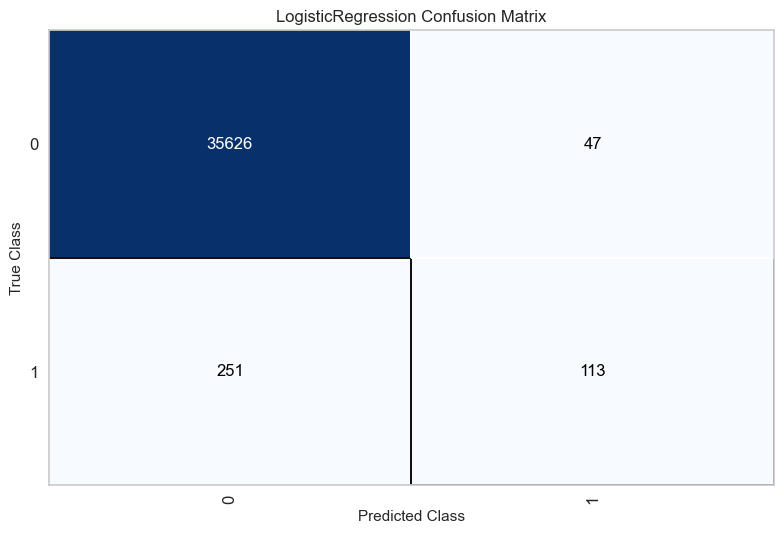

In [57]:
cm = ConfusionMatrix(best_model, cmap="Blues")
cm.score(X_train, y_train)
cm.show();

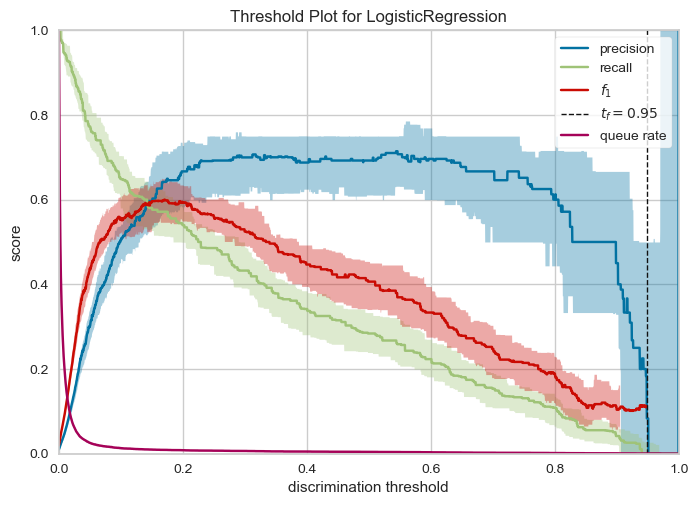

In [58]:
visualizer = DiscriminationThreshold(best_model, quantiles = np.array([0.25, 0.5, 0.75]))

visualizer.fit(X_train, y_train)
visualizer.show();

## Random Forest

In [59]:
rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

pipe = make_pipeline(
    preprocessor,
    rf_clf
)

# More conservative parameter grid
params = {
    "randomforestclassifier__n_estimators": [200, 300, 400],  
    "randomforestclassifier__criterion": ['gini', 'entropy'],
    "randomforestclassifier__max_depth": [10, 12, 15, 20, 25],  # ← NO None!
    "randomforestclassifier__min_samples_split": [10, 20, 30],  # ← Higher
    "randomforestclassifier__min_samples_leaf": [5, 10, 15],  # ← NO 1 or 2!
    "randomforestclassifier__max_features": ['sqrt', 'log2'],
    "randomforestclassifier__max_samples": [0.7, 0.8],  # ← Limit bootstrap samples
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

randomsearch = RandomizedSearchCV(
    pipe,
    params,
    n_iter=100,
    cv=cv,
    scoring="f1",  
    n_jobs=-1,    
    return_train_score=True,
    verbose=2,
    random_state=42
)

randomsearch.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'randomforestclassifier__criterion': ['gini', 'entropy'], 'randomforestclassifier__max_depth': [10, 12, ...], 'randomforestclassifier__max_features': ['sqrt', 'log2'], 'randomforestclassifier__max_samples': [0.7, 0.8], ...}"
,n_iter,100
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [60]:
best_model = randomsearch.best_estimator_

In [61]:
randomsearch.best_score_

np.float64(0.8070751864581247)

In [62]:
y_train_pred_init = best_model.predict(X_train)
print(classification_report(y_train, y_train_pred_init))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35673
           1       0.91      1.00      0.95       364

    accuracy                           1.00     36037
   macro avg       0.95      1.00      0.98     36037
weighted avg       1.00      1.00      1.00     36037



In [63]:
y_val_pred_init = best_model.predict(X_val)
print(classification_report(y_val, y_val_pred_init))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23769
           1       0.80      0.76      0.78       238

    accuracy                           1.00     24007
   macro avg       0.90      0.88      0.89     24007
weighted avg       1.00      1.00      1.00     24007



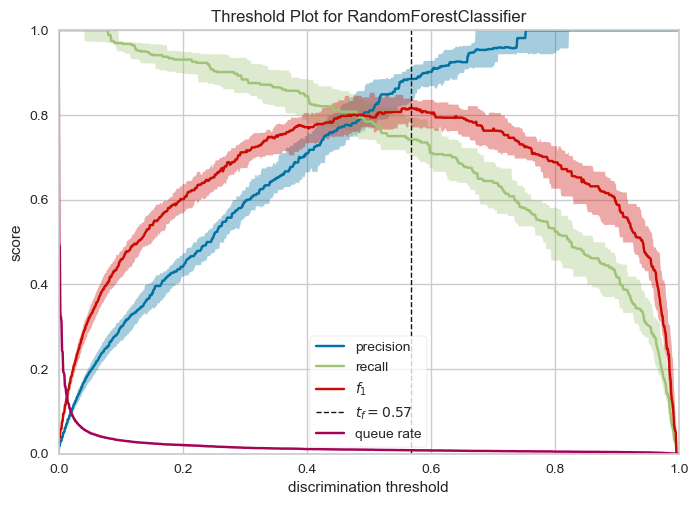

In [64]:
visualizer = DiscriminationThreshold(best_model, quantiles = np.array([0.25, 0.5, 0.75]))

visualizer.fit(X_train, y_train)
visualizer.show();

In [65]:
best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()]
best_threshold

np.float64(0.5676172953081877)

In [66]:
new_pipe = Thresholder(best_model, best_threshold, refit= False)
new_pipe.fit(X_train, y_train)

,model,Pipeline(step...m_state=42))])
,threshold,np.float64(0.5676172953081877)
,refit,False
,check_input,False
,transformer_list,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,include,"['object', 'category']"
,exclude,None


In [67]:
y_train_pred = new_pipe.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35673
           1       0.94      0.97      0.96       364

    accuracy                           1.00     36037
   macro avg       0.97      0.99      0.98     36037
weighted avg       1.00      1.00      1.00     36037



In [68]:
y_val_pred = new_pipe.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23769
           1       0.89      0.71      0.79       238

    accuracy                           1.00     24007
   macro avg       0.94      0.85      0.89     24007
weighted avg       1.00      1.00      1.00     24007



In [69]:
randomsearch.best_params_

{'randomforestclassifier__n_estimators': 400,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__max_samples': 0.8,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__criterion': 'entropy'}

In [71]:
joblib.dump(new_pipe, "pipe.joblib")

['pipe.joblib']

## XGBOOST

In [ ]:
from xgboost import XGBRFClassifier, XGBClassifier